In [110]:
from util_v5 import *
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from matplotlib.ticker import PercentFormatter, FuncFormatter
import seaborn as sns

# 0. Loading and preprocessing

In [111]:
data_dir = "C:\\Users\\DavidJIA\\Desktop\\IC RMFE\\Term 3\\Applied Macro Trading Strategy\\CourseWork\\datasets\\"
# data_dir = './'
# Load and process data
aqms_data = load_aqms_data(data_dir + 'AQMS.xlsx')
bc_data = load_business_cycle_data(data_dir + 'Business Cycle.xls')

In [112]:
# Preprocess asset data
ar, ir = preprocess_asset_data_daily(aqms_data)
mf = preprocess_macro_factors(bc_data, ar, ir)
mf = standardize_column_names(mf)
ar = standardize_column_names(ar)

# Apply transformation on ar
ar = transform_currency_returns(ar.copy())
# Apply transformation on mf
mf = create_us_centric_trade_factors(mf.copy())
mf.ffill(inplace=True)

# Segment time
ar = ar[ar.index >= '1985-01-01']
ir = ir[ir.index >= '1985-01-01']

ar = pd.concat([ar, ir], axis=1)

# 1. Construct portfolio

In [113]:
mp_portfolio = construct_mp_portfolio(ar, mf, vol=0.08);

In [131]:
rs_portfolio = construct_rs_portfolio(ar, mf, vol=0.08);

In [132]:
it_portfolio = construct_it_portfolio(ar, mf, vol=0.08);

In [133]:
bc_portfolio = construct_bc_portfolio(ar, mf, vol=0.08);

In [134]:
final_portfolio = integrate_portfolios(bc_portfolio, it_portfolio, mp_portfolio, rs_portfolio)

# 2. Plotting

### 2.1 Returns

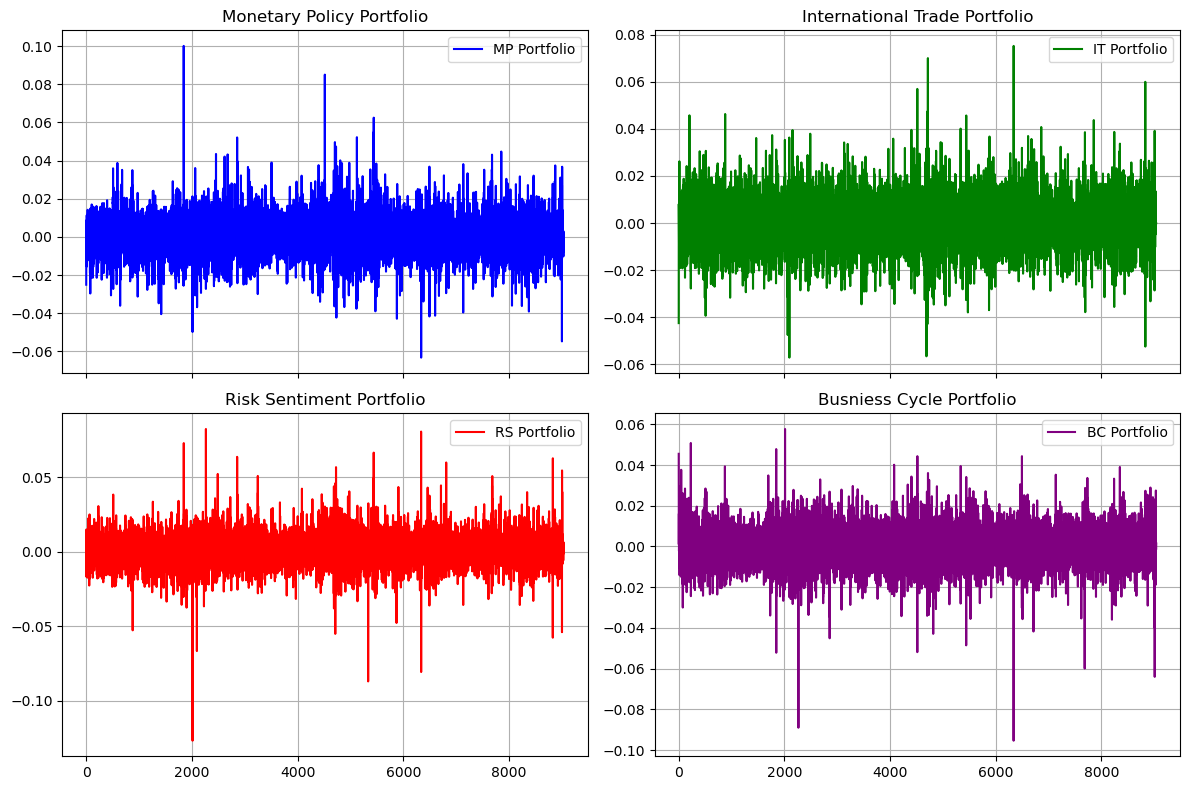

In [135]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# Plot each series in its own subplot
axs[0, 0].plot(mp_portfolio['returns'].values[1500:], label='MP Portfolio', color='blue')
axs[0, 0].set_title('Monetary Policy Portfolio')

axs[0, 1].plot(it_portfolio['returns'].values[1500:], label='IT Portfolio', color='green')
axs[0, 1].set_title('International Trade Portfolio')

axs[1, 0].plot(rs_portfolio['returns'].values[1500:], label='RS Portfolio', color='red')
axs[1, 0].set_title('Risk Sentiment Portfolio')

axs[1, 1].plot(bc_portfolio['returns'].values[1500:], label='BC Portfolio', color='purple')
axs[1, 1].set_title('Busniess Cycle Portfolio')

# Optional: Add legends, grid and tight layout
for ax in axs.flat:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

### 2.2 Cumulative Returns

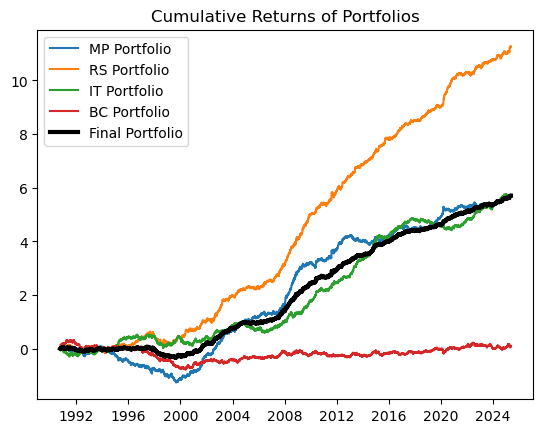

In [136]:
returns_data = [mp_portfolio['returns'].values, 
                rs_portfolio['returns'].values, 
                it_portfolio['returns'].values,
                bc_portfolio['returns'].values,
                final_portfolio['returns'].values]
returns_data = [np.nan_to_num(data, nan=0) for data in returns_data]

labels = ['MP Portfolio', 'RS Portfolio', 'IT Portfolio', 'BC Portfolio', 'Final Portfolio']
for i, data in enumerate(returns_data):
    data = np.where((data > 80) | (data < -80), 0, data)  # Replace extreme values with 0
    data = data[1500:]
    cum_returns = np.cumsum(data)

    # Use a thicker line for "Final Portfolio"
    if labels[i] == 'Final Portfolio':
        plt.plot(mp_portfolio['returns'].index[1500:], cum_returns, label=labels[i], linewidth=3, color='black')
    else:
        plt.plot(mp_portfolio['returns'].index[1500:], cum_returns, label=labels[i], linewidth=1.5)

plt.title('Cumulative Returns of Portfolios')
plt.legend()

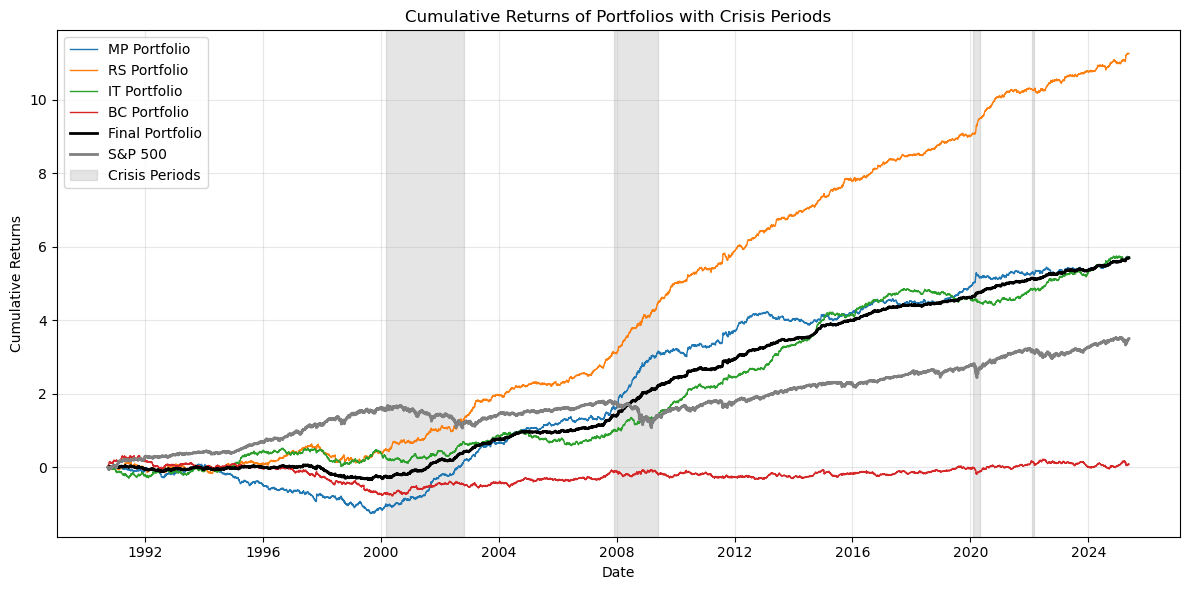

In [196]:
# Define crisis periods (modify with your actual dates)
crisis_periods = [
    ('2000-03-01', '2002-10-31'),  # Burst of dotcom bubble
    ('2007-12-01', '2009-06-01'),  # Global Financial Crisis
    ('2020-02-01', '2020-05-01'),  # COVID-19 Crash
    ('2022-02-01', '2022-03-01'),  # Russia declare war
    # Add more crises as needed
]

returns_data = [mp_portfolio['returns'].values, 
                rs_portfolio['returns'].values, 
                it_portfolio['returns'].values,
                bc_portfolio['returns'].values,
                final_portfolio['returns'].values,
                ar['Equity_US']]

# Clean and process returns
returns_data = [np.nan_to_num(data, nan=0) for data in returns_data]
labels = ['MP Portfolio', 'RS Portfolio', 'IT Portfolio', 'BC Portfolio', 'Final Portfolio', 'S&P 500']

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot cumulative returns
for i, data in enumerate(returns_data):
    data = np.where((data > 80) | (data < -80), 0, data)
    data = data[1500:]
    cum_returns = np.cumsum(data)
    
    # Use thicker line for final portfolio
    if labels[i] == 'Final Portfolio':
        ax.plot(mp_portfolio['returns'].index[1500:], cum_returns, 
                label=labels[i], linewidth=2, color='black')
    elif labels[i] == 'S&P 500':
        ax.plot(mp_portfolio['returns'].index[1500:], cum_returns, 
                label=labels[i], linewidth=2, color='gray')
    else:
        ax.plot(mp_portfolio['returns'].index[1500:], cum_returns, 
                label=labels[i], linewidth=1)

# Add crisis period shading WITHOUT any label
for start, end in crisis_periods:
    ax.axvspan(start, end, color='gray', alpha=0.2)  # No label parameter!

# Create a custom patch for the legend
crisis_patch = mpatches.Patch(color='gray', alpha=0.2, label='Crisis Periods')

# Get existing legend handles and labels
handles, labels_legend = ax.get_legend_handles_labels()

# Add custom patch to the legend items
handles.append(crisis_patch)  # Add crisis patch to end
# Or insert at beginning: handles.insert(0, crisis_patch)

# Apply the combined legend
ax.legend(handles=handles, loc='best')

# Configure plot
plt.title('Cumulative Returns of Portfolios with Crisis Periods')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(handles=handles, loc='best')  # Use custom handles
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 2.3 Metrics

Max Drawdown

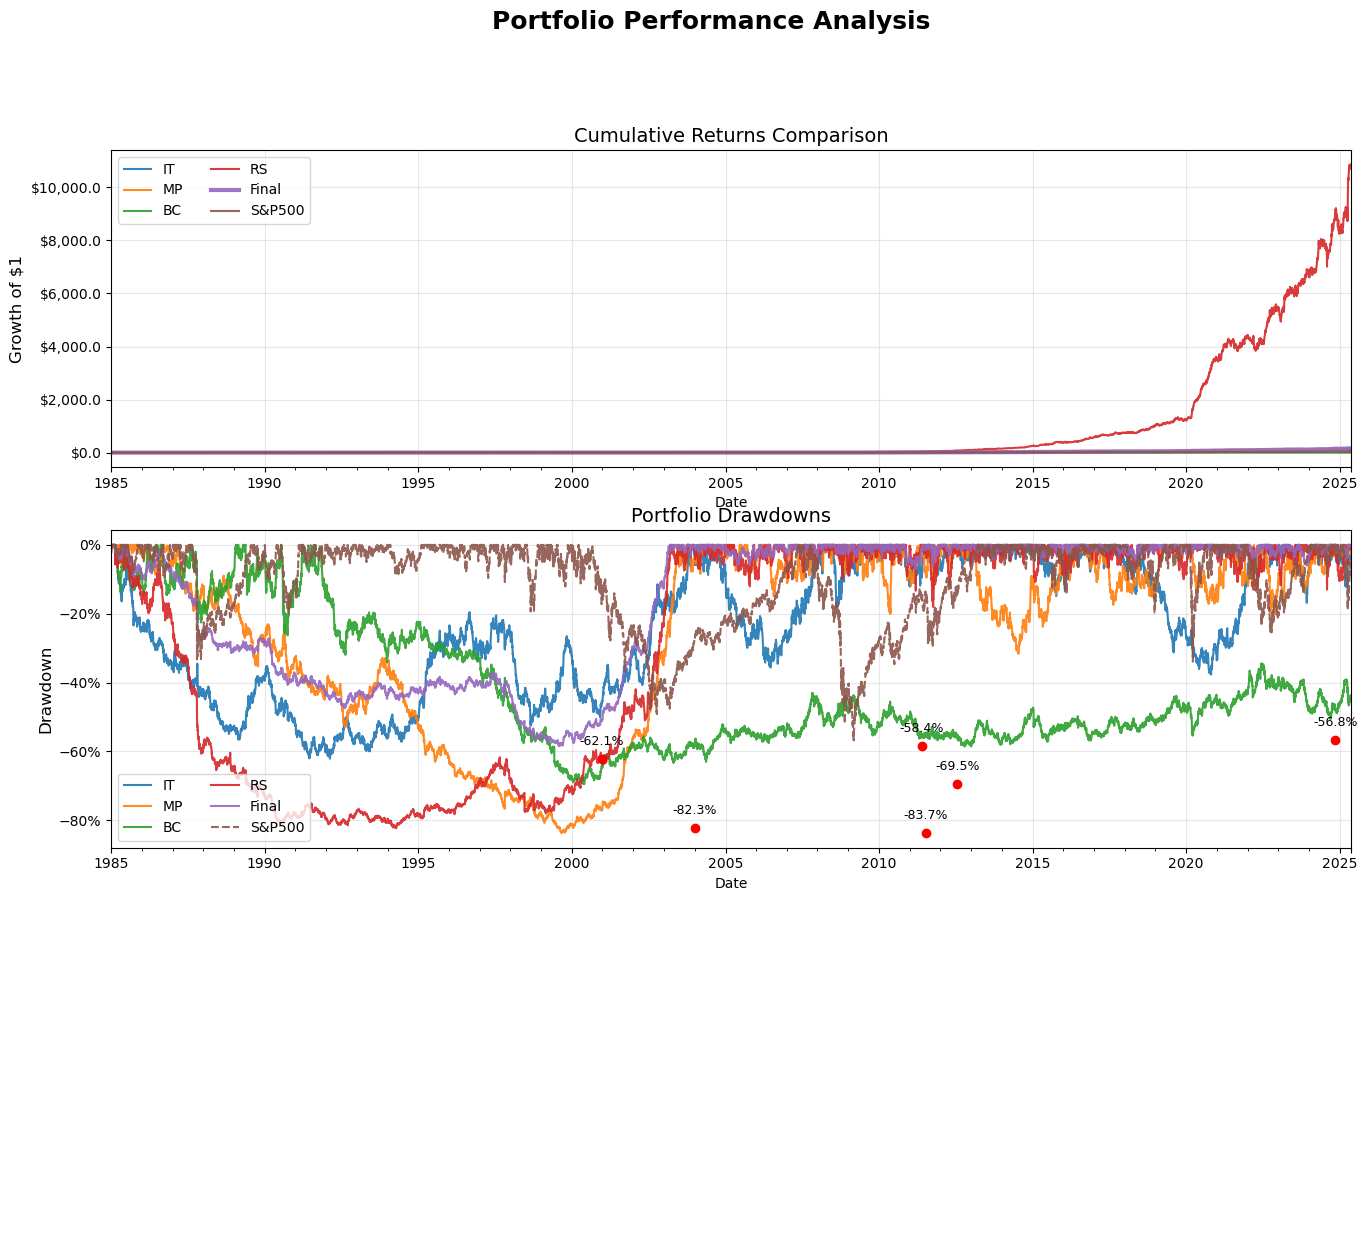

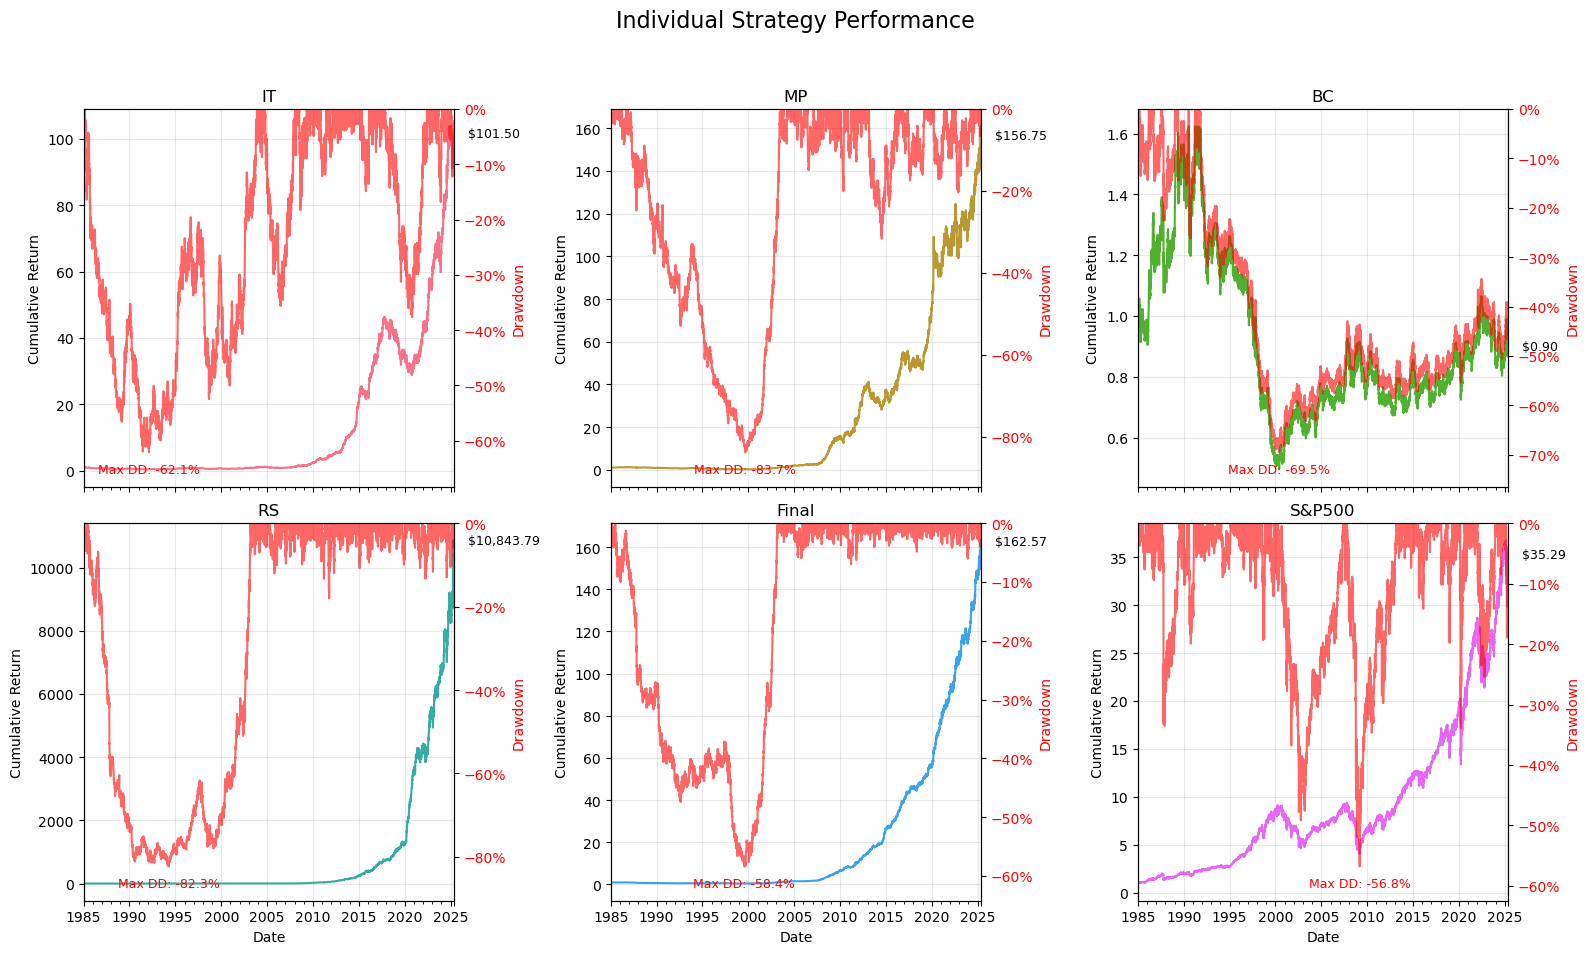

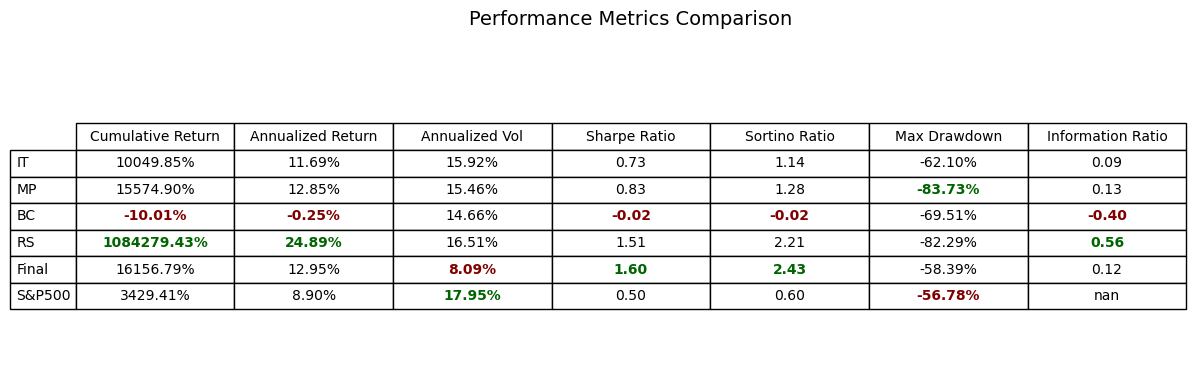

In [187]:
# Create returns DataFrame with aligned data
returns_df = pd.DataFrame({
    'IT': it_portfolio['returns'],
    'MP': mp_portfolio['returns'],
    'BC': bc_portfolio['returns'],
    'RS': rs_portfolio['returns'],
    'Final': final_portfolio['returns'],
    'S&P500': ar['Equity_US']
})

# =====================
# 2. PERFORMANCE CALCULATIONS
# =====================

# Calculate cumulative returns
cumulative_returns = (1 + returns_df).cumprod()

# Calculate drawdowns
def calculate_drawdowns(cum_returns):
    peak = cum_returns.expanding(min_periods=1).max()
    return (cum_returns - peak) / peak

drawdowns = calculate_drawdowns(cumulative_returns)

# Calculate max drawdown
max_drawdown = drawdowns.min()
max_dd_duration = drawdowns.apply(lambda x: x.eq(0).astype(int).groupby(x.ne(0).cumsum()).cumsum())

# =====================
# 3. VISUALIZATION
# =====================

plt.figure(figsize=(16, 14))
plt.suptitle('Portfolio Performance Analysis', fontsize=18, fontweight='bold')

# ---------------------
# 3.1 Cumulative Returns
# ---------------------
ax1 = plt.subplot(3, 1, 1)
for col in cumulative_returns.columns:
    # Highlight final portfolio with thicker line
    lw = 3 if col == 'Final' else 1.5
    cumulative_returns[col].plot(ax=ax1, label=col, linewidth=lw, alpha=0.9)

ax1.set_title('Cumulative Returns Comparison', fontsize=14)
ax1.set_ylabel('Growth of $1', fontsize=12)
ax1.legend(loc='best', ncol=2)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.1f}'))

# ---------------------
# 3.2 Drawdown Comparison
# ---------------------
ax2 = plt.subplot(3, 1, 2)
for col in drawdowns.columns:
    # Highlight S&P500 with different style
    style = '--' if col == 'S&P500' else '-'
    drawdowns[col].plot(ax=ax2, label=col, linestyle=style, alpha=0.9)

# Highlight max drawdown points
for col in drawdowns.columns:
    idx = drawdowns[col].idxmin()
    ax2.plot(idx, drawdowns[col].min(), 'ro', markersize=6)
    ax2.annotate(f'{drawdowns[col].min():.1%}', 
                (idx, drawdowns[col].min()),
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=9)

ax2.set_title('Portfolio Drawdowns', fontsize=14)
ax2.set_ylabel('Drawdown', fontsize=12)
ax2.legend(loc='lower left', ncol=2)
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(PercentFormatter(1.0))

# ---------------------
# 3.3 Small Multiples - Individual Strategies
# ---------------------
ax3 = plt.subplot(3, 1, 3)
ax3.axis('off')  # We'll create individual axes below

# Create grid for small multiples
fig, axes = plt.subplots(2, 3, figsize=(16, 10), sharex=True)
axes = axes.flatten()

strategies = list(returns_df.columns)
colors = sns.color_palette("husl", len(strategies))

for i, strategy in enumerate(strategies):
    if i >= len(axes): 
        break
        
    ax = axes[i]
    
    # Primary axis - Cumulative returns
    cumulative_returns[strategy].plot(ax=ax, color=colors[i], label='Equity')
    ax.set_title(strategy, fontsize=12)
    ax.set_ylabel('Cumulative Return')
    ax.grid(True, alpha=0.3)
    
    # Add final value annotation
    final_val = cumulative_returns[strategy].iloc[-1]
    ax.annotate(f"${final_val:,.2f}", 
                xy=(cumulative_returns.index[-1], final_val),
                xytext=(10, 0), 
                textcoords='offset points',
                ha='left', 
                va='center',
                fontsize=9)
    
    # Secondary axis - Drawdown
    ax2 = ax.twinx()
    drawdowns[strategy].plot(ax=ax2, color='red', alpha=0.6, label='Drawdown')
    ax2.set_ylabel('Drawdown', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax2.set_ylim(drawdowns[strategy].min() * 1.1, 0)  # Add 10% buffer
    
    # Add max drawdown annotation
    min_dd = drawdowns[strategy].min()
    min_dd_date = drawdowns[strategy].idxmin()
    ax2.annotate(f'Max DD: {min_dd:.1%}',
                xy=(min_dd_date, min_dd),
                xytext=(0, -15),
                textcoords='offset points',
                ha='center',
                color='red',
                fontsize=9)

# Hide unused axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')
    
plt.suptitle('Individual Strategy Performance', fontsize=16, y=0.95)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

# =====================
# 4. METRICS TABLE
# =====================

# Calculate performance metrics
def calculate_metrics(returns, benchmark_returns):
    # Annualization factor
    days = len(returns)
    ann_factor = 252 / days
    
    # Cumulative return
    cumulative_return = (1 + returns).prod() - 1
    
    # Annualized return
    annualized_return = (1 + cumulative_return) ** ann_factor - 1
    
    # Volatility
    volatility = returns.std() * np.sqrt(252)
    
    # Sharpe ratio (assume 0 risk-free rate for simplicity)
    sharpe = annualized_return / volatility
    
    # Sortino ratio
    downside_returns = returns[returns < 0]
    downside_vol = downside_returns.std() * np.sqrt(252)
    sortino = annualized_return / downside_vol if downside_vol > 0 else np.nan
    
    # Max drawdown
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.expanding(min_periods=1).max()
    drawdown = (cum_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # Information ratio
    active_returns = returns - benchmark_returns
    active_return = active_returns.mean() * 252
    tracking_error = active_returns.std() * np.sqrt(252)
    info_ratio = active_return / tracking_error if tracking_error > 0 else np.nan
    
    return {
        'Annualized Return': annualized_return,
        'Annualized Vol': volatility,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown': max_drawdown,
        'Information Ratio': info_ratio,
        'Cumulative Return': cumulative_return
    }

# Calculate metrics for each strategy
metrics_data = {}
benchmark_returns = returns_df['S&P500']  # Benchmark for Information Ratio

for strategy in returns_df.columns:
    if strategy == 'S&P500':
        # Use market benchmark for S&P500 itself
        metrics_data[strategy] = calculate_metrics(returns_df[strategy], returns_df[strategy])
    else:
        metrics_data[strategy] = calculate_metrics(returns_df[strategy], benchmark_returns)

# Create metrics DataFrame
metrics_df = pd.DataFrame(metrics_data).T
metrics_df = metrics_df[['Cumulative Return', 'Annualized Return', 'Annualized Vol', 
                         'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown', 'Information Ratio']]

# Format metrics for display
metrics_formatted = metrics_df.copy()
percent_cols = ['Cumulative Return', 'Annualized Return', 'Annualized Vol', 'Max Drawdown']
for col in percent_cols:
    metrics_formatted[col] = metrics_formatted[col].apply(lambda x: f"{x:.2%}")
    
ratio_cols = ['Sharpe Ratio', 'Sortino Ratio', 'Information Ratio']
for col in ratio_cols:
    metrics_formatted[col] = metrics_formatted[col].apply(lambda x: f"{x:.2f}")

# Create metrics table
plt.figure(figsize=(12, 4))
ax = plt.gca()
ax.axis('off')

table = ax.table(
    cellText=metrics_formatted.values,
    rowLabels=metrics_formatted.index,
    colLabels=metrics_formatted.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.15] * len(metrics_formatted.columns))
    
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Highlight best and worst performers
for j, col in enumerate(metrics_df.columns):
    if col in ['Max Drawdown']:
        best_idx = metrics_df[col].idxmin()
        worst_idx = metrics_df[col].idxmax()
    else:
        best_idx = metrics_df[col].idxmax()
        worst_idx = metrics_df[col].idxmin()
    
    best_i = list(metrics_df.index).index(best_idx)
    worst_i = list(metrics_df.index).index(worst_idx)
    
    table[(best_i+1, j)].set_text_props(weight='bold', color='darkgreen')
    table[(worst_i+1, j)].set_text_props(weight='bold', color='maroon')

plt.title('Performance Metrics Comparison', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Mean Return, Mean STD, Sharpe, Sortino and Information Ratios 

In [194]:
portfolios = {
    'it_portfolio': it_portfolio,
    'mp_portfolio': mp_portfolio,
    'bc_portfolio': bc_portfolio,
    'rs_portfolio': rs_portfolio,
    'final_portfolio': final_portfolio
}

# Sharpe & Sortino
for i, j in portfolios.items():
    mean_ret = ((1+j['returns'].mean())**252-1)*100
    std = j['returns'].std()*np.sqrt(252)*100
    
    rf_daily = (1 + aqms_data['Interest Rates_FDTR Index']/100) ** (1/252) - 1
    er_rf = j['returns'] - rf_daily
    sharpe_ratio = er_rf.mean() / er_rf.std() * np.sqrt(252)
    
    downside_returns = er_rf[er_rf < 0]
    downside_std = downside_returns.std()
    sortino_ratio = er_rf.mean() / downside_std * np.sqrt(252)
    
    # Information ratio
    er_sp = j['returns'] - ar['Equity_US']
    er_gb = j['returns'] - (1 + aqms_data['Bond Yield 2Y_USGG2YR Index']/100) ** (1/252) + 1
    info_ratio_sp = er_sp.mean() / er_sp.std() * np.sqrt(252)
    info_ratio_gb = er_gb.mean() / er_gb.std() * np.sqrt(252)
    
    print(f"Performance Metrics for {i}\n"
          f"----------------------------------------\n"
          f"Annualized Mean Return: {mean_ret:.2f}%\n"
          f"Annualized Standard Deviation: {std:.2f}%\n"
          f"Sharpe Ratio    : {sharpe_ratio:.3f}\n"
          f"Sortino Ratio   : {sortino_ratio:.3f}\n"
          f"Information Ratio vs S&P500 : {info_ratio_sp:.3f}\n"
          f"Information Ratio vs US2YTB : {info_ratio_gb:.3f}\n"
          f"=========================================\n")

Performance Metrics for it_portfolio
----------------------------------------
Annualized Mean Return: 13.11%
Annualized Standard Deviation: 15.92%
Sharpe Ratio    : 0.560
Sortino Ratio   : 0.866
Information Ratio vs S&P500 : 0.092
Information Ratio vs US2YTB : 0.541

Performance Metrics for mp_portfolio
----------------------------------------
Annualized Mean Return: 14.21%
Annualized Standard Deviation: 15.46%
Sharpe Ratio    : 0.639
Sortino Ratio   : 0.986
Information Ratio vs S&P500 : 0.134
Information Ratio vs US2YTB : 0.619

Performance Metrics for bc_portfolio
----------------------------------------
Annualized Mean Return: 0.83%
Annualized Standard Deviation: 14.66%
Sharpe Ratio    : -0.176
Sortino Ratio   : -0.248
Information Ratio vs S&P500 : -0.398
Information Ratio vs US2YTB : -0.197

Performance Metrics for rs_portfolio
----------------------------------------
Annualized Mean Return: 26.60%
Annualized Standard Deviation: 16.51%
Sharpe Ratio    : 1.223
Sortino Ratio   : 1.79

In [190]:
print(type(final_portfolio['returns'].index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


### 2.4 Correlation

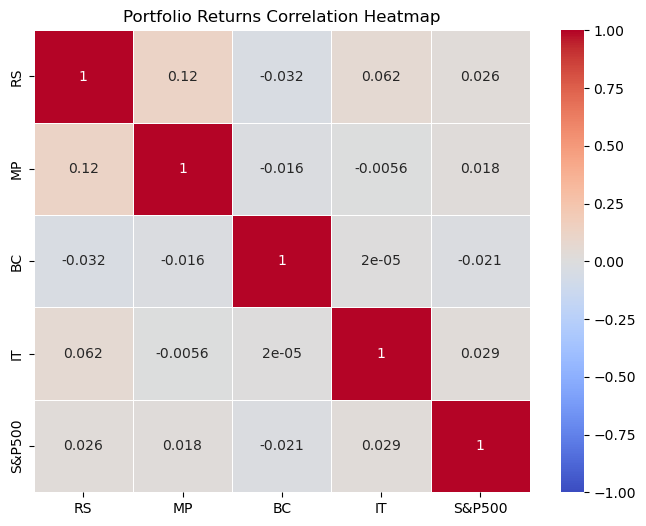

In [188]:
# 1. Combine returns into a DataFrame
data = {
    'RS': rs_portfolio['returns'],
    'MP': mp_portfolio['returns'],
    'BC': bc_portfolio['returns'],
    'IT': it_portfolio['returns'],
    'S&P500': ar['Equity_US']
}
df = pd.DataFrame(data)

# 2. Calculate correlation matrix
corr_matrix = df.corr()

# 3. Generate heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,          # Show correlation values
    cmap='coolwarm',     # Blue (negative) to red (positive) colormap
    vmin=-1, vmax=1,     # Fix scale from -1 to 1
    linewidths=0.5       # Add grid lines
)
plt.title("Portfolio Returns Correlation Heatmap")
plt.show()

### 2.5 Results over decades

In [195]:
import numpy as np
import pandas as pd

# Define decade periods (start inclusive, end exclusive)
decades = [
    ('1985-1995', '1985-01-01', '1995-01-01'),
    ('1995-2005', '1995-01-01', '2005-01-01'),
    ('2005-2015', '2005-01-01', '2015-01-01'),
    ('2015-2025', '2015-01-01', '2025-01-01')
]

# Portfolio names to analyze
portfolio_names = ['it_portfolio', 'mp_portfolio', 'bc_portfolio', 'rs_portfolio', 'final_portfolio']

# Initialize results dictionary
results = {metric: [] for metric in ['Decade', 'Metric'] + portfolio_names}

# Calculate metrics for each decade
for decade_name, start_date, end_date in decades:
    # Get risk-free rate for the decade
    rf_decade = aqms_data['Interest Rates_FDTR Index'].loc[start_date:end_date]
    
    # Calculate daily risk-free returns
    rf_daily = (1 + rf_decade/100) ** (1/252) - 1
    
    # Prepare to store Sharpe/Sortino for all portfolios
    decade_sharpe = []
    decade_sortino = []
    
    for port_name in portfolio_names:
        # Get portfolio returns for the decade
        port_returns = portfolios[port_name]['returns'].loc[start_date:end_date]
        
        # Align returns with risk-free rate
        common_dates = port_returns.index.intersection(rf_daily.index)
        aligned_returns = port_returns.loc[common_dates]
        aligned_rf = rf_daily.loc[common_dates]
        
        # Skip calculation if insufficient data
        if len(aligned_returns) < 10:
            decade_sharpe.append(np.nan)
            decade_sortino.append(np.nan)
            continue
        
        # Calculate excess returns
        excess_returns = aligned_returns - aligned_rf
        
        # Sharpe ratio
        sharpe = excess_returns.mean() / excess_returns.std() * np.sqrt(252)
        
        # Sortino ratio (downside deviation)
        downside_returns = excess_returns[excess_returns < 0]
        downside_std = downside_returns.std() if len(downside_returns) > 1 else 0
        sortino = excess_returns.mean() / downside_std * np.sqrt(252) if downside_std > 0 else np.nan
        
        decade_sharpe.append(sharpe)
        decade_sortino.append(sortino)
    
    # Add decade results to output
    results['Decade'].extend([decade_name, decade_name])
    results['Metric'].extend(['Sharpe', 'Sortino'])
    
    for i, port_name in enumerate(portfolio_names):
        results[port_name].extend([decade_sharpe[i], decade_sortino[i]])

# Create formatted DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.set_index(['Decade', 'Metric'])

# Display results
print("\nPortfolio Performance by Decade")
print("=" * 75)
print(results_df.to_string(float_format="{:,.3f}".format))
print("=" * 75)


Portfolio Performance by Decade
                   it_portfolio  mp_portfolio  bc_portfolio  rs_portfolio  final_portfolio
Decade    Metric                                                                          
1985-1995 Sharpe         -0.757        -0.758        -0.170        -1.196           -1.480
          Sortino        -1.104        -1.007        -0.228        -1.591           -1.907
1995-2005 Sharpe          0.308         0.556        -0.539         1.027            0.725
          Sortino         0.479         0.919        -0.779         1.463            1.088
2005-2015 Sharpe          1.658         1.622         0.038         2.807            2.828
          Sortino         2.553         2.714         0.057         4.483            4.686
2015-2025 Sharpe          0.942         0.823        -0.047         2.129            1.999
          Sortino         1.543         1.258        -0.065         3.340            3.255
